# Image Processing
* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [63]:
import rasterio
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shapefile
import affine
import statistics

from sklearn.model_selection import train_test_split
from pyproj import Transformer
from collections import Counter

from IAdeforestation.preprocessing import *
from IAdeforestation.tools import *

# Load Shapefile

In [64]:
LABELS_PATH = 'labels'
SHAPEFILES_PATHS = [os.path.join(LABELS_PATH, 'central_highlands_1_other', 'central_highlands_1_other.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_test', 'central_highlands_2_test.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_other', 'central_highlands_2_other.shp')]

SHAPEFILE_ESPG=4326

points = process_shapefile(SHAPEFILES_PATHS)

# Create output image tree

In [65]:
OUTPUT_DIR = 'D:/fall_images'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    for i in range(-1,33):
        os.mkdir(os.path.join(OUTPUT_DIR, str(i)))

# Get all Sentinel images

In [66]:
SENTINEL_IMAGES_PATH = 'D:\Fall'

paths = []
LIMIT = 4
i = 0
for p in os.listdir(SENTINEL_IMAGES_PATH):
    i=0
    for pp in os.listdir(os.path.join(SENTINEL_IMAGES_PATH, p)):
        if i < LIMIT:
            paths.append(os.path.join(p, pp))
        i+=1

In [67]:
paths

['a\\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZT_20210216T060024',
 'a\\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZT_20210226T055551',
 'a\\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZT_20210318T052447',
 'a\\S2B_MSIL1C_20210221T030739_N0209_R075_T48PZT_20210221T045842',
 'b\\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZU_20210216T060024',
 'b\\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZU_20210226T055551',
 'b\\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZU_20210318T052447',
 'b\\S2B_MSIL1C_20210313T030539_N0209_R075_T48PZU_20210313T060451',
 'c\\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZV_20210216T060024',
 'c\\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZV_20210226T055551',
 'c\\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZV_20210318T052447',
 'c\\S2A_MSIL1C_20210328T030541_N0209_R075_T48PZV_20210328T060538',
 'd\\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZA_20210216T060024',
 'd\\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZA_20210226T055551',
 'd\\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZ

# Split and export images

In [68]:
TARGET_IMG_SIZE = 64 # Image size (width*height)
NUMBER_OF_SPLIT = 171 # Number of split in big image, causion large image size > that TARGET_IMG_SIZE * NUMBER_OF_SPLIT
i = 0

for sentinel_image_path in paths:
    raster_paths = get_raster_paths(os.path.join(SENTINEL_IMAGES_PATH, sentinel_image_path)) # Get each raster path
    raster_dict = load_raster_img(raster_paths) # Load each raster
    image_dict = resample_bands(raster_dict)

    l = list(image_dict.values())
    final_img = np.asarray(l)
    split_export_img(final_img, 
                     raster_dict['B02'], 
                     points, 
                     img_prefix=str(i), 
                     crop_size=TARGET_IMG_SIZE,
                     split_size=NUMBER_OF_SPLIT,
                     export_folder=OUTPUT_DIR)
    print(f"{sentinel_image_path} ready")
    print(len(os.listdir("D:\\fall_images\\2")))
    i += 1

a\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZT_20210216T060024 ready
368
a\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZT_20210226T055551 ready
736
a\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZT_20210318T052447 ready
1104
a\S2B_MSIL1C_20210221T030739_N0209_R075_T48PZT_20210221T045842 ready
1472
b\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZU_20210216T060024 ready
1503
b\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZU_20210226T055551 ready
1534
b\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZU_20210318T052447 ready
1565
b\S2B_MSIL1C_20210313T030539_N0209_R075_T48PZU_20210313T060451 ready
1596
c\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZV_20210216T060024 ready
1614
c\S2A_MSIL1C_20210226T030701_N0209_R075_T48PZV_20210226T055551 ready
1632
c\S2A_MSIL1C_20210318T030541_N0209_R075_T48PZV_20210318T052447 ready
1650
c\S2A_MSIL1C_20210328T030541_N0209_R075_T48PZV_20210328T060538 ready
1668
d\S2A_MSIL1C_20210216T030811_N0209_R075_T48PZA_20210216T060024 ready
1769
d\S2A_MSIL1C_20210226T030701_N0209_R075_

In [11]:
NB_SELECTED_VAL = 100000
dict_val = dict.fromkeys(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A'])

for band in dict_val.keys():
    dict_val[band] = np.array([])
    
for path in paths:
    raster_paths = get_raster_paths(os.path.join(SENTINEL_IMAGES_PATH, path)) # Get each raster path
    raster_dict = load_raster_img(raster_paths) # Load each raster
    image_dict = resample_bands(raster_dict)

    l = list(image_dict.values())
    final_img = np.asarray(l)

    for i, band_name in enumerate(dict_val.keys()):
        dict_val[band_name] = np.append(dict_val[band_name], 
                                        np.random.choice(final_img[i].flatten(),NB_SELECTED_VAL, replace=False))
    print(path)

Fall\a
Fall\b
Fall\c
Fall\d
Fall\e
Spring\a
Spring\b
Spring\c
Spring\d
Spring\e
Summer\a
Summer\b
Summer\c
Summer\d
Summer\e
Winter\a
Winter\b
Winter\c
Winter\d
Winter\e


In [12]:
dict_mean = dict.fromkeys(dict_val.keys())
dict_std = dict.fromkeys(dict_val.keys())

for band in dict_val.keys():
    dict_mean[band] = statistics.mean(dict_val[band])
    dict_std[band] = statistics.stdev(dict_val[band])

In [13]:
dict_mean

{'B01': 1505.3912245,
 'B02': 1262.278884,
 'B03': 1188.270451,
 'B04': 1038.9751485,
 'B05': 1298.016616,
 'B06': 2304.750201,
 'B07': 2820.626611,
 'B08': 2676.388643,
 'B09': 568.939934,
 'B10': 18.29427,
 'B11': 2073.8799665,
 'B12': 1170.6030005,
 'B8A': 3105.341244}

In [14]:
dict_std

{'B01': 981.0595285790714,
 'B02': 1055.6179992139178,
 'B03': 1044.5322001484756,
 'B04': 1181.0540245679736,
 'B05': 1098.2968767668983,
 'B06': 1104.3583924379755,
 'B07': 1235.1890691868484,
 'B08': 1169.186500135096,
 'B09': 348.91136284684853,
 'B10': 25.334801244398527,
 'B11': 1134.6082535123755,
 'B12': 918.6739574276703,
 'B8A': 1300.942717213371}

In [17]:
def compute_dataset_mean_std(paths, dict_meanfinal_img, band_names, sentinel_image_path):
    dict_val = dict.fromkeys(band_names)
    
    for path in paths[0:1]:
        raster_paths = get_raster_paths(os.path.join(SENTINEL_IMAGES_PATH, path)) # Get each raster path
        raster_dict = load_raster_img(raster_paths) # Load each raster
        image_dict = resample_bands(raster_dict)

        l = list(image_dict.values())
        final_img = np.asarray(l)
        

        for i, band_name in enumerate(dict_mean.keys()):
            dict_mean[band_name] = final_img[i].flatten()

# Statistics
## Shapefile statistics

In [5]:
label_occ = []

for shape in SHAPEFILES_PATHS:
    sf = shapefile.Reader(shape)
    for point in sf.records():
        label_occ.append(point[0])

Text(0.5, 1.0, 'Shapefile class occcurence')

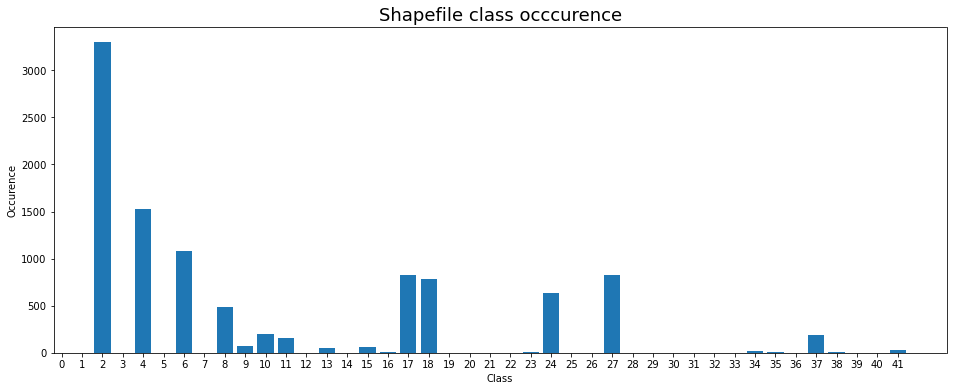

In [8]:
_, ax = plt.subplots(figsize=(16, 6))
c = Counter(label_occ)
ax.set_xticks(np.arange(42))
ax.bar(c.keys(), c.values())
ax.set_xlabel('Class')
ax.set_ylabel('Occurence')
ax.set_title("Shapefile class occcurence", fontsize=18)

## Saved image (on disk) statistics

Text(0.5, 1.0, 'Final image class occcurence')

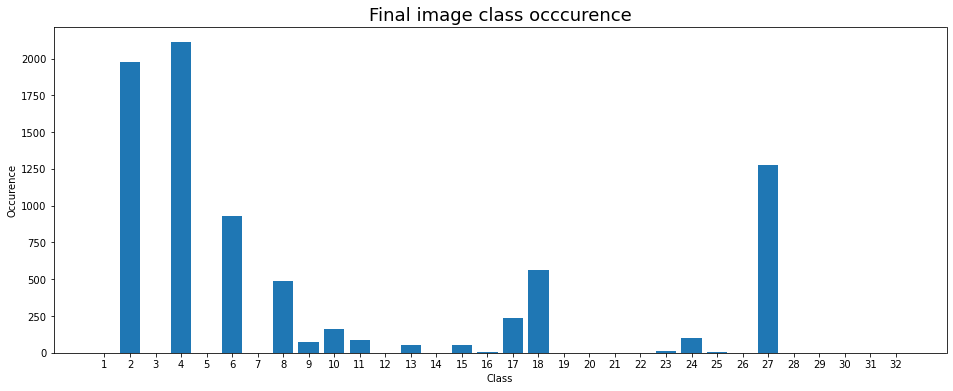

In [31]:
class_occ = {}
paths = [int(i) for i in  os.listdir('images')[2:]]
paths.sort()
for i in paths:
    class_occ[str(i)] = len(os.listdir('images/' + str(i)))
    
_, ax = plt.subplots(figsize=(16, 6))
ax.bar(class_occ.keys(), class_occ.values())
ax.set_xlabel('Class')
ax.set_ylabel('Occurence')
ax.set_title("Final image class occcurence", fontsize=18)

## Image coordinates verification
The goal is to verify that the algorithm that cuts the images assigns the right geographic coordinates to the right portion of the image. 

![notebook_images\CoordCheck.PNG](notebook_images\CoordCheck.PNG)

An easily identifiable image was used. It is the beach with a clear separation between water and sand. On top of the image you can see the two geographic points generated (top left and bottom right).

![notebook_images\CoordCheckGMaps.PNG](notebook_images\CoordCheckGMaps.PNG)

By inserting the 2 coordinates in google maps we can see that the bounding box formed by the two points (red arrow on google maps) corresponds well to the image cut by the algorithm.

## Image labeling verification
The goal is to verify that the images have been properly labeled and displaying image classes that are easily recognizable like :
* Water
* Urban
* Rice

### Water 

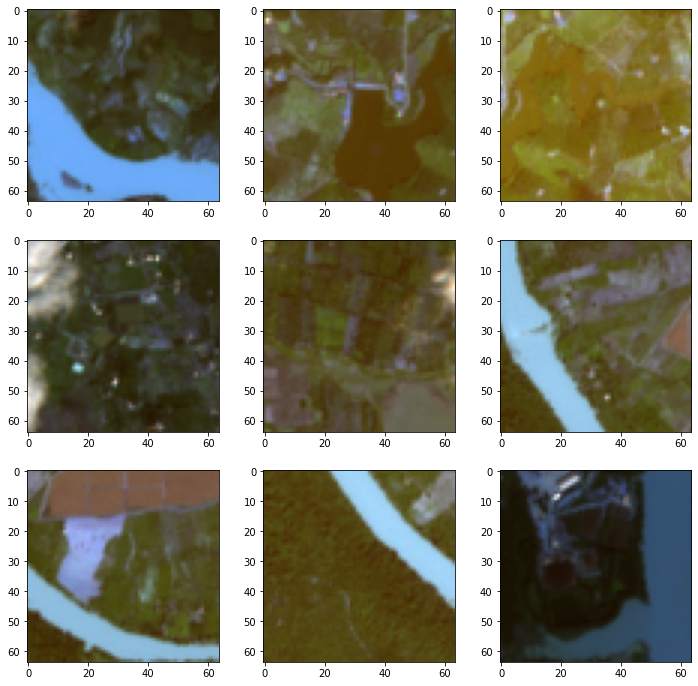

In [8]:
WATERPATH = 'images/10/'
water_paths = [os.path.join(WATERPATH, s) for s in os.listdir(WATERPATH)]
show_grid_img(water_paths)

### Urban

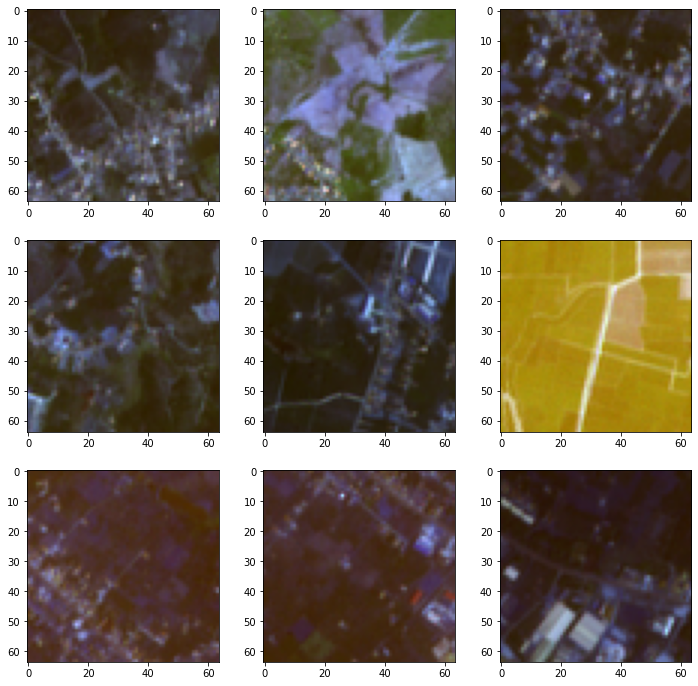

In [3]:
WATERPATH = 'images/9/'
water_paths = [os.path.join(WATERPATH, s) for s in os.listdir(WATERPATH)]
show_grid_img(water_paths[10:19])

### Rice

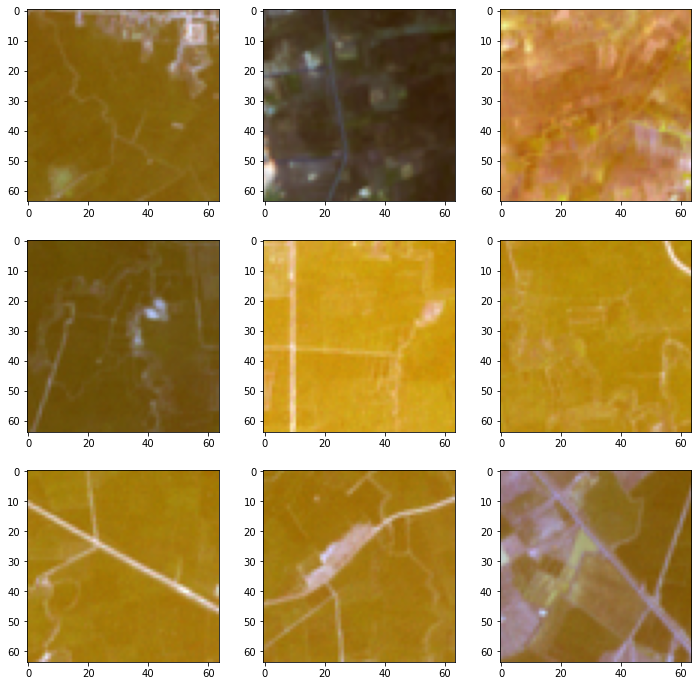

In [4]:
WATERPATH = 'images/18/'
water_paths = [os.path.join(WATERPATH, s) for s in os.listdir(WATERPATH)]
show_grid_img(water_paths[110:129])

## Statistics

In [127]:
eurosat_mean = [1353.036, 1116.468, 1041.475, 945.344, 1198.498, 2004.878, 2376.699, 2303.738, 732.957, 12.092, 1818.820, 1116.271, 2602.579]
eurosat_std = [65.479, 154.008, 187.997, 278.508, 228.122, 356.598, 456.035, 531.570, 98.947, 1.188, 378.993, 303.851, 503.181]

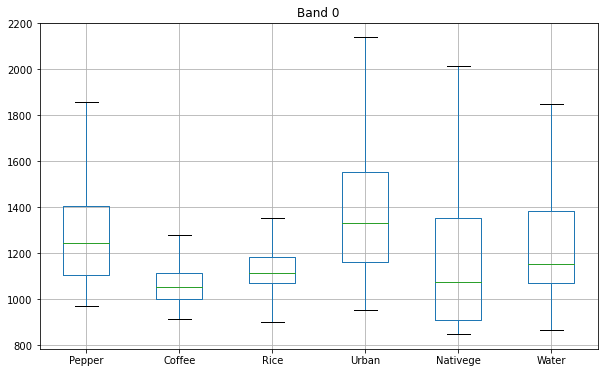

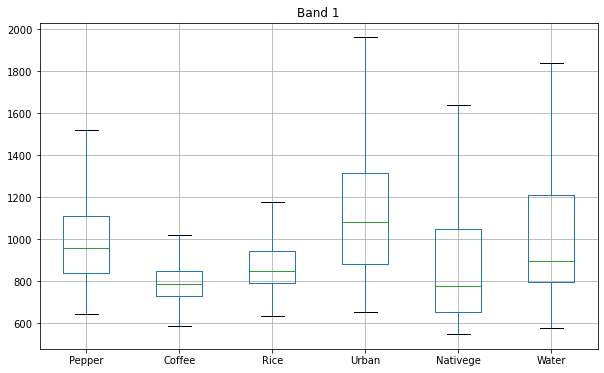

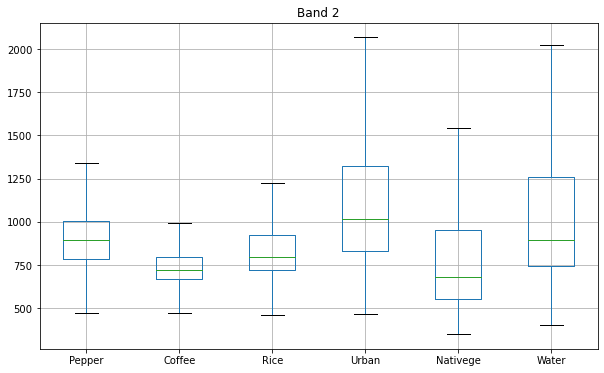

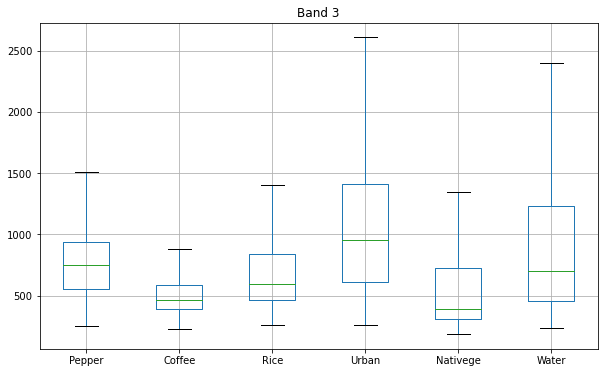

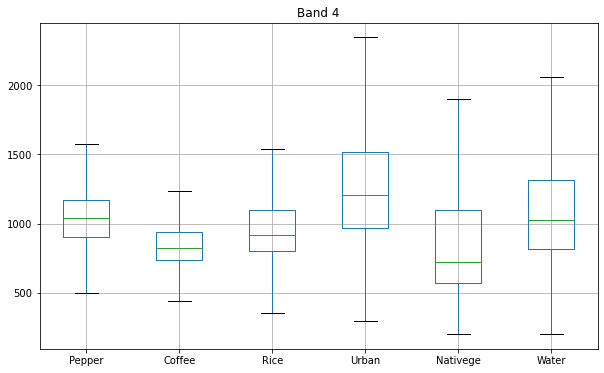

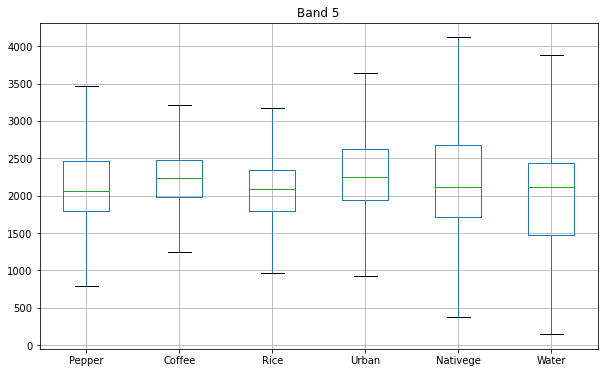

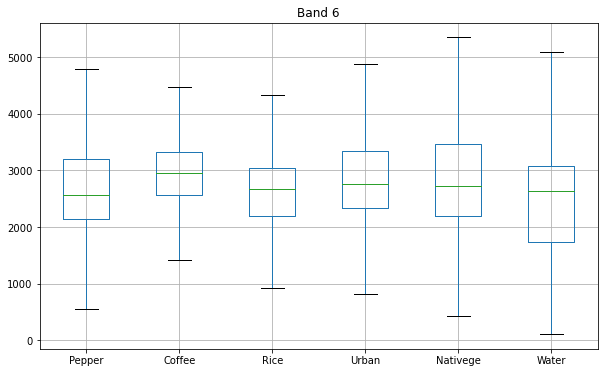

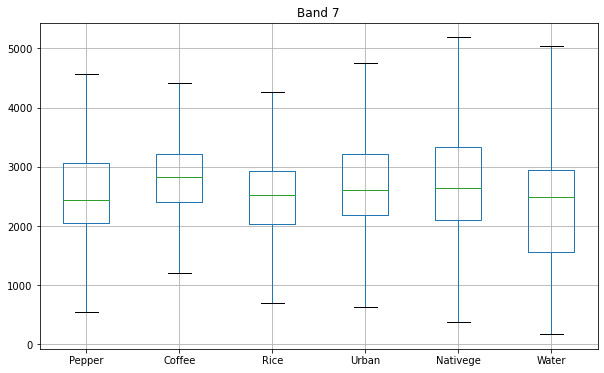

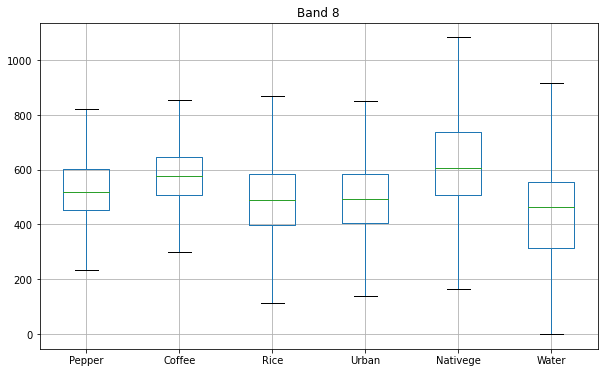

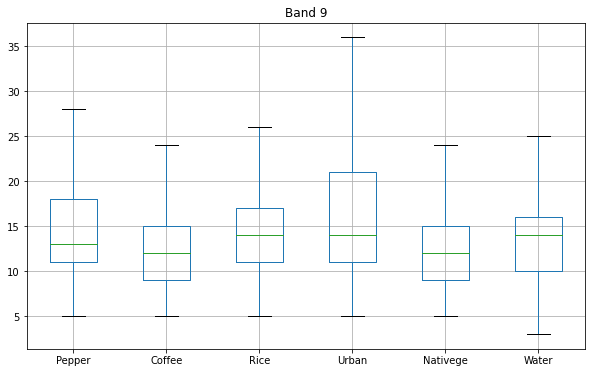

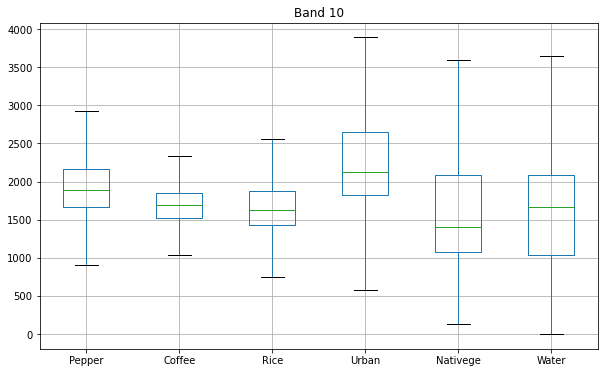

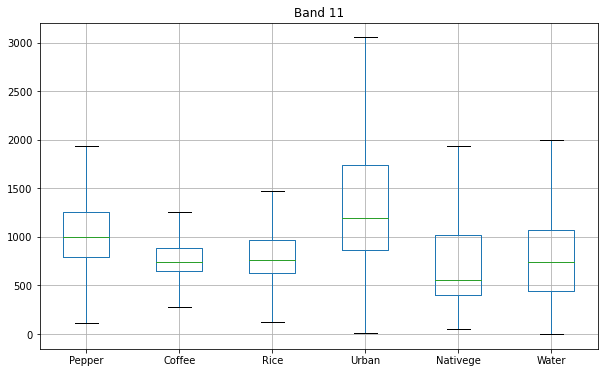

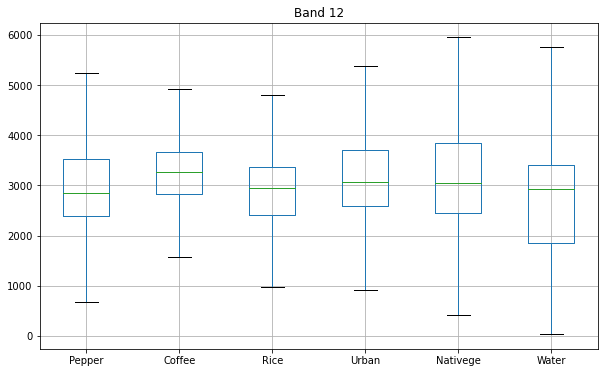

In [128]:
categories = {'Pepper':15, 'Coffee':2, 'Rice':18, 'Urban':9, 'Nativege':4, 'Water':10}
dict_output = {}
for cat, number in categories.items():
    dict_output[cat] = {}
    
    for band in range(0,13):
        dict_output[cat][band] = []
    
    for path in os.listdir(os.path.join('images', str(number)))[0:50]:
        img = np.float32(rasterio.open(os.path.join('images', str(number),path)).read())
        img = np.float32(np.moveaxis(img, 0, -1))

        for band in range(0,13):
            dict_output[cat][band].extend(img[:,:,band].flatten())
            
for band in range(0,13):
    df = pd.DataFrame()
    for cat,number in categories.items():
        df[cat] = dict_output[cat][band]
    
    fig, ax = plt.subplots(figsize=(10,6))
    df.boxplot(ax=ax, showfliers=False)
    ax.set_title(f"Band {band}")
    

<AxesSubplot:title={'center':'Band mean per image cytegory'}, ylabel='None'>

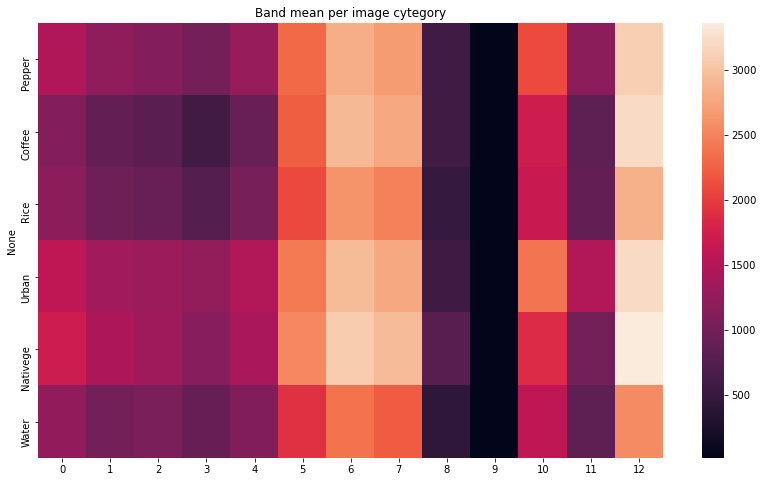

In [129]:
df = pd.DataFrame(columns=range(0,13), index=[list(dict_output.keys())])
for band in range(0,13):

    mean =[]
    for cat,number in categories.items():
        mean.append(statistics.mean(dict_output[cat][band]))
    df[band] = mean
                         
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlabel('Bands')
ax.set_ylabel('Image category')
ax.set_title('Band mean per image cytegory')
    
sns.heatmap(df, ax=ax)

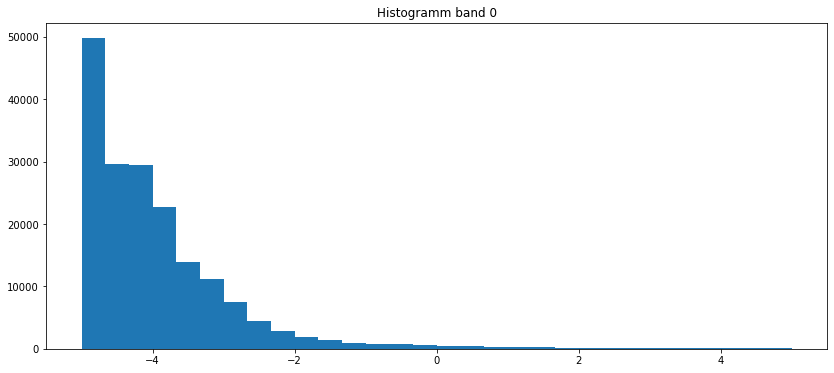

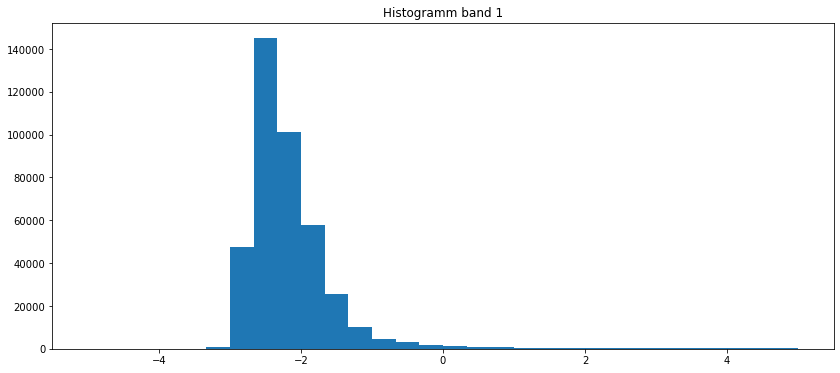

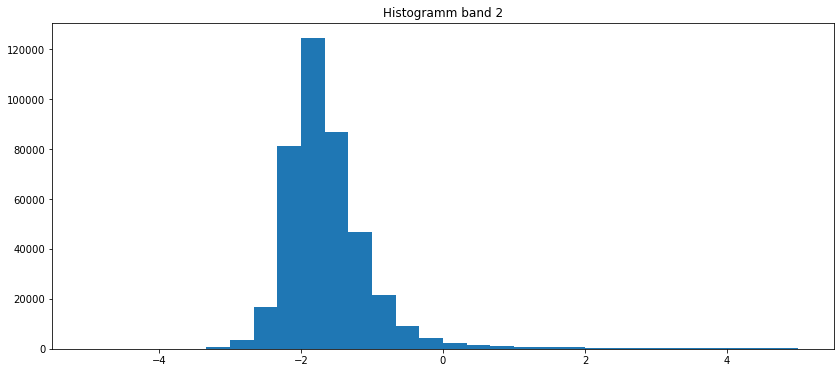

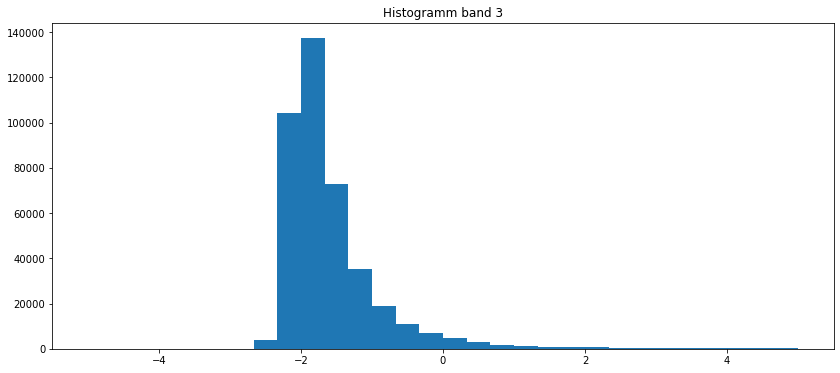

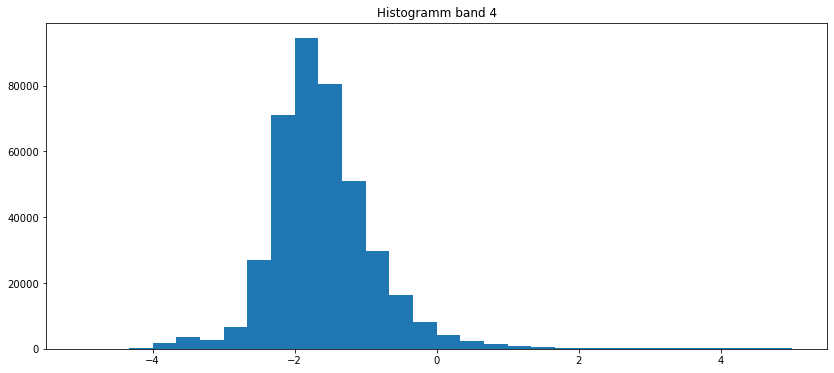

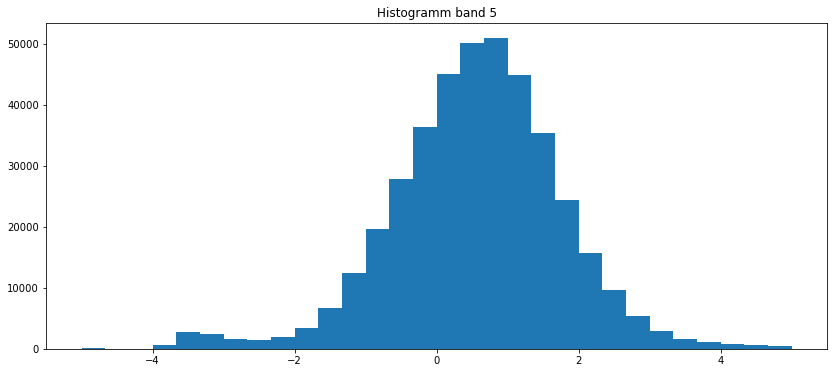

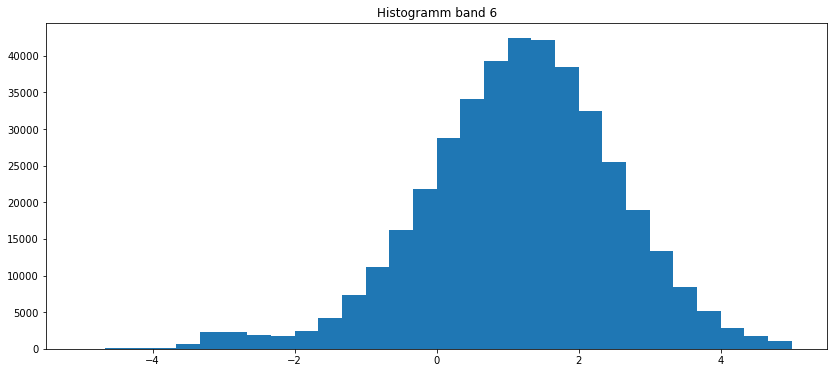

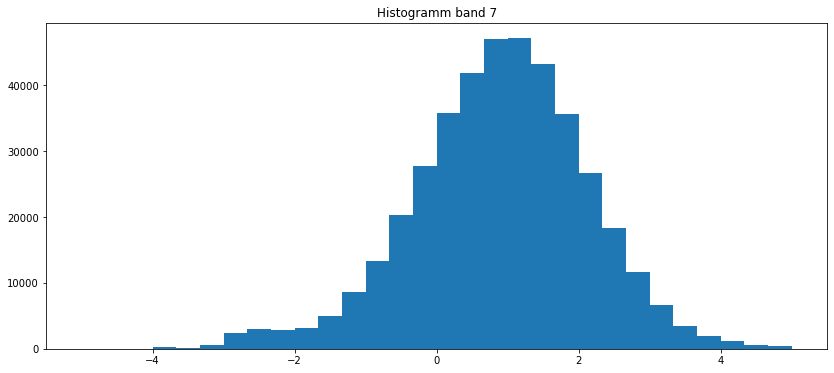

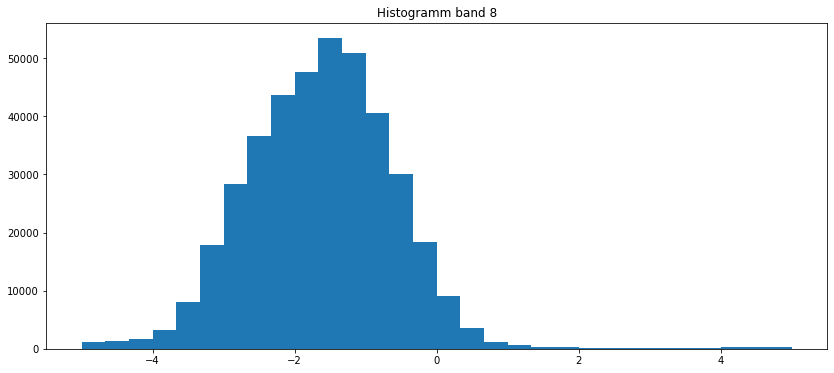

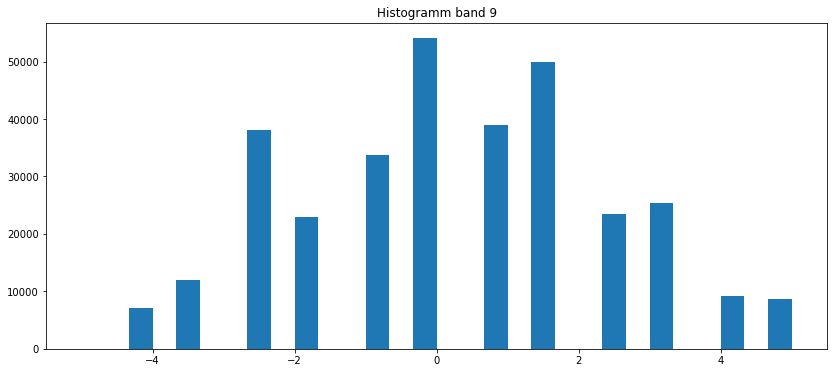

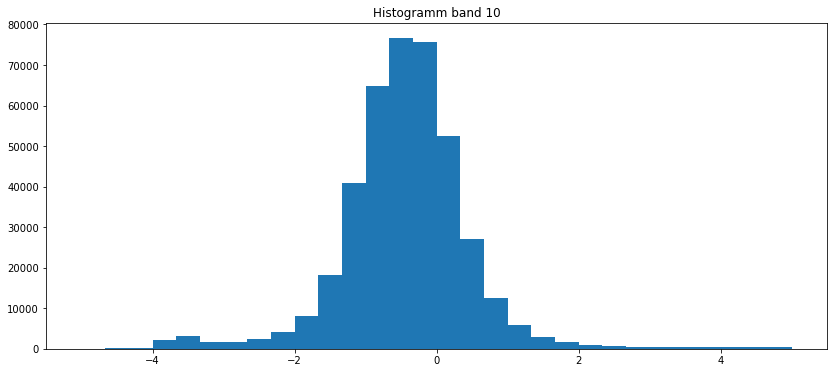

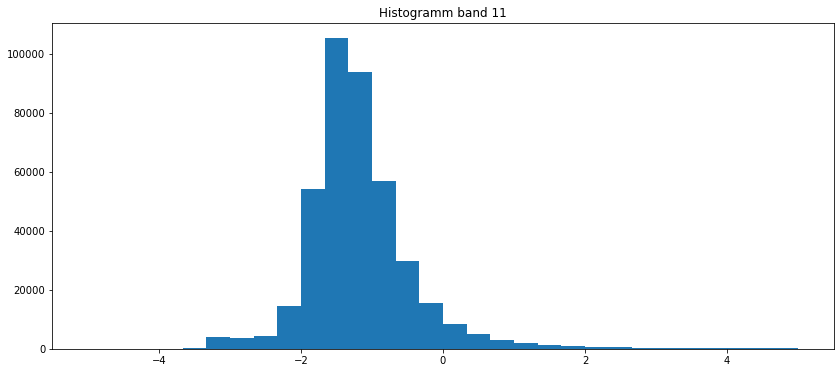

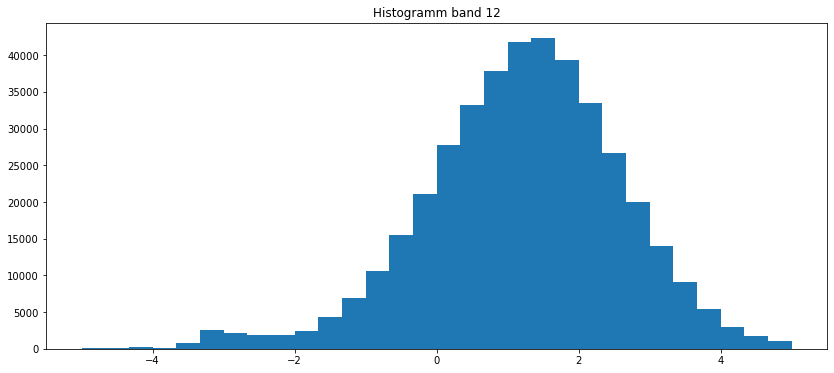

In [130]:
COFFEE_PATH = os.path.join('images', '2')

dict_bands = {}

for band in range(0,13):
    dict_bands[band] = []
    
paths = os.listdir(COFFEE_PATH)
    
for path in paths[0:100]:
    img = np.float32(rasterio.open(os.path.join(COFFEE_PATH, path)).read())
    img = np.moveaxis(img, 0, -1)
    img = normalize(img, eurosat_mean, eurosat_std)
    
    for band in range(0,13):
        dict_bands[band].extend(img[:,:,band].flatten())
        
for n, v in dict_bands.items():
    fig, ax = plt.subplots(figsize=(14,6))
    ax.hist(v, range=[-5,5], bins=30)
    ax.set_title(f"Histogramm band {n}")

In [108]:
COFFEE_PATH = os.path.join('images', '2')
SEASONS = ['Fall', 'Winter']
seasons_dict = {}

for s in SEASONS:
    seasons_dict[s] = []

for p in os.listdir(COFFEE_PATH):
    for s in SEASONS:
        if s in p:
            seasons_dict[s].append(os.path.join(COFFEE_PATH, p))

In [111]:
boxplot_dict= {}

for name, season_paths in seasons_dict.items():
    
    dict_bands = {}
    for band in range(0,13):
        dict_bands[band] = {'Fall':[], 'Winter':[]}
    
    for path in season_paths:
        img = rasterio.open(path).read()
        
        df_bands = pd.DataFrame()
        for band in range(0,13):
            #dict_bands[band].extend(img[band,:,:].flatten())
            dict_bands[band][name].extend(img[band,:,:].flatten())
            

    #boxplot_dict[name] = pd.DataFrame.from_dict(dict_bands)
            

In [112]:
pd.DataFrame.from_dict(dict_bands[0])

ValueError: arrays must all be same length